Initialize spark context 

In [1]:
from pyspark.sql import SparkSession
spark=SparkSession.builder.appName('linear_regrssion').getOrCreate()

In [2]:
from pyspark.ml.regression import LinearRegression

Read data from csv file

In [3]:
data = spark.read.csv("cruise_ship_info.csv", inferSchema=True,header=True)

Import libraries for visualization

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
df_lr = pd.read_csv(r"cruise_ship_info.csv")

Print dataframe schema

In [6]:
data.printSchema()

root
 |-- Ship_name: string (nullable = true)
 |-- Cruise_line: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tonnage: double (nullable = true)
 |-- passengers: double (nullable = true)
 |-- length: double (nullable = true)
 |-- cabins: double (nullable = true)
 |-- passenger_density: double (nullable = true)
 |-- crew: double (nullable = true)



In [7]:
data.describe()

DataFrame[summary: string, Ship_name: string, Cruise_line: string, Age: string, Tonnage: string, passengers: string, length: string, cabins: string, passenger_density: string, crew: string]

In [8]:
data.show()

+-----------+-----------+---+------------------+----------+------+------+-----------------+----+
|  Ship_name|Cruise_line|Age|           Tonnage|passengers|length|cabins|passenger_density|crew|
+-----------+-----------+---+------------------+----------+------+------+-----------------+----+
|    Journey|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|
|      Quest|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|
|Celebration|   Carnival| 26|            47.262|     14.86|  7.22|  7.43|             31.8| 6.7|
|   Conquest|   Carnival| 11|             110.0|     29.74|  9.53| 14.88|            36.99|19.1|
|    Destiny|   Carnival| 17|           101.353|     26.42|  8.92| 13.21|            38.36|10.0|
|    Ecstasy|   Carnival| 22|            70.367|     20.52|  8.55|  10.2|            34.29| 9.2|
|    Elation|   Carnival| 15|            70.367|     20.52|  8.55|  10.2|            34.29| 9.2|
|    Fantasy|   Carnival| 23| 

In [9]:
data.head()

Row(Ship_name='Journey', Cruise_line='Azamara', Age=6, Tonnage=30.276999999999997, passengers=6.94, length=5.94, cabins=3.55, passenger_density=42.64, crew=3.55)

In [10]:
for item in data.head():
 print(item)

Journey
Azamara
6
30.276999999999997
6.94
5.94
3.55
42.64
3.55


In [11]:
data.groupBy('Cruise_line').count().show()

+-----------------+-----+
|      Cruise_line|count|
+-----------------+-----+
|            Costa|   11|
|              P&O|    6|
|           Cunard|    3|
|Regent_Seven_Seas|    5|
|              MSC|    8|
|         Carnival|   22|
|          Crystal|    2|
|           Orient|    1|
|         Princess|   17|
|        Silversea|    4|
|         Seabourn|    3|
| Holland_American|   14|
|         Windstar|    3|
|           Disney|    2|
|        Norwegian|   13|
|          Oceania|    3|
|          Azamara|    2|
|        Celebrity|   10|
|             Star|    6|
|  Royal_Caribbean|   23|
+-----------------+-----+



##### Plot graph

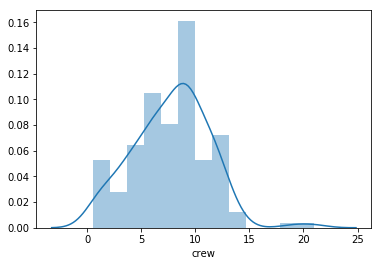

In [12]:
sns.distplot(df_lr['crew'])

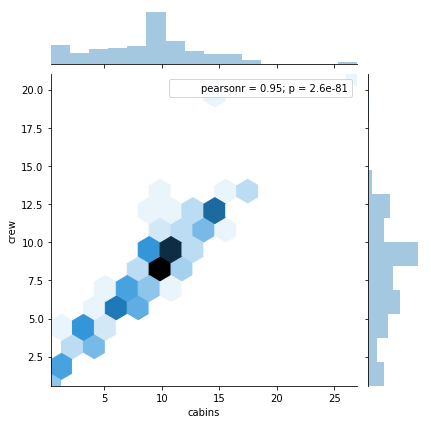

In [13]:
sns.jointplot(x = "cabins", y = "crew", data = df_lr, kind = 'hex')

In [14]:
numeric_features = [t[0] for t in data.dtypes if t[1] == 'int' or t[1] == 'double']

In [15]:
corr = data.select(numeric_features).sample(False, 0.10).toPandas()

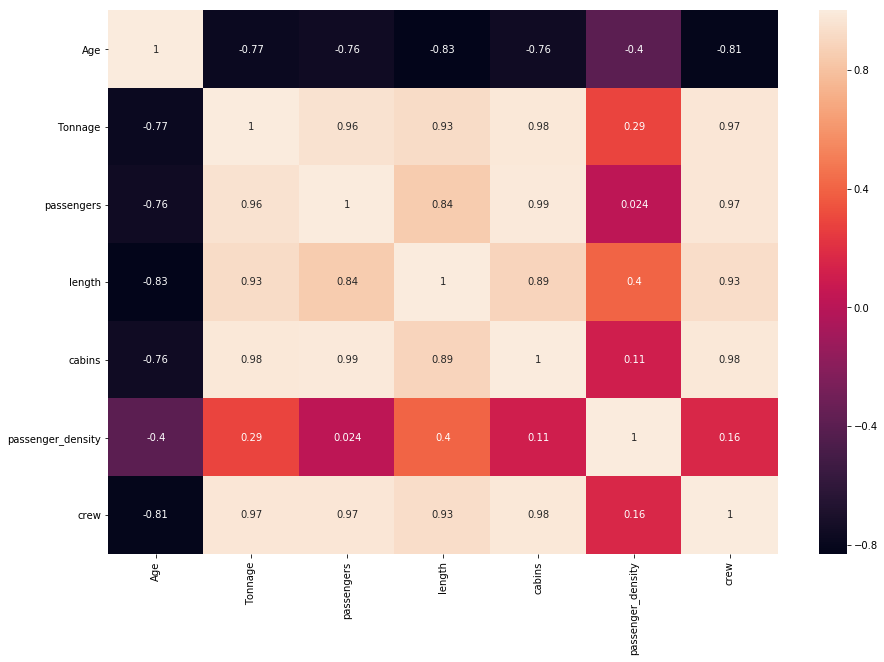

In [16]:
heatmap = sns.heatmap(data=corr.corr(), annot=True)
heatmap.figure.set_size_inches(15,10)

#### Scale Data

In [27]:
from pyspark.ml.feature import (VectorIndexer,
                               OneHotEncoder,StringIndexer)

In [28]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [29]:
data.columns

['Ship_name',
 'Cruise_line',
 'Age',
 'Tonnage',
 'passengers',
 'length',
 'cabins',
 'passenger_density',
 'crew']

In [30]:
Cruise_line_indexer = StringIndexer(inputCol='Cruise_line',outputCol='Cruise_line_Index')
model = Cruise_line_indexer .fit(data)
td = model.transform(data)

In [31]:
assembler = VectorAssembler(
    inputCols = ["Age", "Tonnage", "passengers", "length", "cabins", "passenger_density","Cruise_line_Index"],
    outputCol = "features")

In [32]:
output= assembler.transform(td)

In [33]:
output.show()

+-----------+-----------+---+------------------+----------+------+------+-----------------+----+-----------------+--------------------+
|  Ship_name|Cruise_line|Age|           Tonnage|passengers|length|cabins|passenger_density|crew|Cruise_line_Index|            features|
+-----------+-----------+---+------------------+----------+------+------+-----------------+----+-----------------+--------------------+
|    Journey|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|             16.0|[6.0,30.276999999...|
|      Quest|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|             16.0|[6.0,30.276999999...|
|Celebration|   Carnival| 26|            47.262|     14.86|  7.22|  7.43|             31.8| 6.7|              1.0|[26.0,47.262,14.8...|
|   Conquest|   Carnival| 11|             110.0|     29.74|  9.53| 14.88|            36.99|19.1|              1.0|[11.0,110.0,29.74...|
|    Destiny|   Carnival| 17|           101.353|

In [34]:
final_data=output.select("features","crew")

In [35]:
train_data,test_data=final_data.randomSplit([0.7,0.3])

In [36]:
train_data.describe().show()

+-------+-----------------+
|summary|             crew|
+-------+-----------------+
|  count|              104|
|   mean|8.050480769230777|
| stddev|3.615676058339559|
|    min|             0.59|
|    max|             21.0|
+-------+-----------------+



#### Train Model

In [37]:
linearR=LinearRegression(labelCol="crew")

In [38]:
linearRModel=linearR.fit(train_data)

In [39]:
print("Coefficients: {} Intercept: {}".format(linearRModel.coefficients,linearRModel.intercept))

Coefficients: [-0.010608390037624375,-0.012124421077740746,-0.14766630875302691,0.3825379084439843,1.0517906936051777,0.016187480316238245,0.04999179673777044] Intercept: -1.7101050893510301


#### Evaluate Model

In [40]:
test_results = linearRModel.evaluate(test_data)

In [41]:
test_results.residuals.show()

+--------------------+
|           residuals|
+--------------------+
|   2.113845576231882|
|  -1.170625738260581|
|   0.416181805178768|
|  0.2637129500580446|
| 0.13057269434131058|
| -0.9515834796679208|
|  0.3437238011363828|
|  0.7366429370660228|
|-0.48867383176615853|
| -0.7664965033985585|
| -0.7997922553749959|
|-0.08214601906941432|
|-0.13046863597984437|
| 0.12911239432627397|
|-0.12527753654225648|
|  2.1076966026159454|
| 0.11025664197234875|
|  -0.664834445845603|
|  0.9494228635781123|
|  0.2977553129408962|
+--------------------+
only showing top 20 rows



In [42]:
unlabeled_data = test_data.select('features')

In [43]:
predictions=linearRModel.transform(unlabeled_data)

In [44]:
predictions.show()

+--------------------+------------------+
|            features|        prediction|
+--------------------+------------------+
|[5.0,122.0,28.5,1...| 4.586154423768118|
|[6.0,90.0,20.0,9....|10.170625738260581|
|[6.0,93.0,23.94,9...|10.673818194821232|
|[6.0,110.23899999...|11.236287049941955|
|[6.0,113.0,37.82,...| 11.86942730565869|
|[7.0,116.0,31.0,9...| 12.95158347966792|
|[9.0,81.0,21.44,9...| 9.656276198863617|
|[9.0,88.5,21.24,9...| 9.563357062933978|
|[9.0,90.09,25.01,...| 9.178673831766158|
|[9.0,105.0,27.2,8...|11.446496503398558|
|[9.0,110.0,29.74,...|12.399792255374996|
|[9.0,116.0,26.0,9...|11.082146019069414|
|[10.0,68.0,10.8,7...| 6.490468635979845|
|[10.0,77.0,20.16,...| 8.870887605673726|
|[10.0,90.09,25.01...| 8.705277536542257|
|[10.0,151.4,26.2,...|10.422303397384054|
|[11.0,58.6,15.66,...| 7.489743358027651|
|[11.0,85.0,18.48,...| 8.664834445845603|
|[11.0,91.0,20.32,...| 9.040577136421888|
|[12.0,2.329,0.94,...|0.3022446870591038|
+--------------------+------------

In [45]:
print("RMSE: {}".format(test_results.rootMeanSquaredError))
print("MSE: {}".format(test_results.meanSquaredError))
print("R2: {}".format(test_results.r2))

RMSE: 0.7073762032312083
MSE: 0.5003810928977998
R2: 0.9517974512069253


Check Corelation between crew-passenger and crew-cabin

In [47]:
from pyspark.sql.functions import corr
data.select(corr('crew','cabins')).show()
data.select(corr('crew','passengers')).show()

+------------------+
|corr(crew, cabins)|
+------------------+
|0.9508226063578497|
+------------------+

+----------------------+
|corr(crew, passengers)|
+----------------------+
|    0.9152341306065384|
+----------------------+

